In [16]:
from __future__ import print_function
import keras,sklearn
# suppress tensorflow compilation warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab as pl

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv1D, MaxPooling2D
from keras import backend as kb
from keras import regularizers

from scipy import stats, math, interpolate
from scipy import optimize
from scipy.interpolate import CubicSpline

import random

import sys

#import complex ode solver for Sch. Equation
#from odeintw import odeintw
import odeintw as oiw

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

## Define functions to create the dataset
Here, we create some functions that make generating greatly varying datasets easy to do

In [101]:
def calcPerfData(Bx, By, Bz, psi0, tvec):
    # Determine number of steps
    steps = len(tvec)
    
    # Declare pauli matrices
    sigmax = np.zeros([2,2],dtype='complex')
    sigmay = np.zeros([2,2],dtype='complex')
    sigmaz = np.zeros([2,2],dtype='complex')

    sigmax[0,1] = 1.0
    sigmax[1,0] = 1.0

    sigmaz[0,0] = 1.0
    sigmaz[1,1] = -1.0

    sigmay[0,1] = -1.0*1j
    sigmay[1,0] = 1.0*1j
    
    # Declare states to project to
    psix = np.zeros([2,1],dtype='complex')
    psiy = np.zeros([2,1],dtype='complex')
    psiz = np.zeros([2,1],dtype='complex')

    psix[0] = 1/np.sqrt(2)
    psix[1] = 1/np.sqrt(2)

    psiy[0] = 1/np.sqrt(2)
    psiy[1] = 1j/np.sqrt(2)

    psiz[0] = 1
    psiz[1] = 0
    
    # Create the derivative as -i*H, Hamiltonian
    def evolve(psi,t):
        dpsi =  -1j * np.dot( Bx(t)*sigmax + By(t)*sigmay + Bz(t)*sigmaz, psi)
        return dpsi
    
    # Integrate to get the solution
    psi0use       = np.reshape(np.transpose(psi0),2)
    solution      = np.zeros([steps,2],dtype='complex')
    solution[:,:] = oiw.odeintw(evolve,psi0use,tspace)
    
    # Initialize the output
    probabilities = np.zeros([steps,3])
    
    # Get the probabilities by dotting the solution (a stepsx2) into the states (a 2x1) for each operator
    probabilities[:,0] = np.square(np.abs(np.dot(np.conj(solution), psix))).reshape(steps)
    probabilities[:,1] = np.square(np.abs(np.dot(np.conj(solution), psiy))).reshape(steps)
    probabilities[:,2] = np.square(np.abs(np.dot(np.conj(solution), psiz))).reshape(steps)
    
    expectations = 2*probabilities-1
    return probabilities, expectations





def calcNoisyData(probabilities, Nmeas, meanNorm, stdNorm):
    if Nmeas > 0:
        expectNoisy = 2*np.random.binomial(Nmeas, probabilities)/Nmeas - 1
    else:
        expectNoisy = 2*probabilities - 1
        
    expectNoisy = expectNoisy + stdNorm*np.random.randn(np.shape(probabilities)[0],3) + meanNorm
    return expectNoisy





def createDataSet(Ndata, Bx, By, Bz, psi0mat, tspace, noiseData, noiseLabel=np.array([0,0,0])):
    # Get Parameters and such
    #Ndata = np.shape(psi0mat)[1] # Psi0 is always a 2xN
    steps = len(tspace)
    
    NmeasLabl  = noiseLabel[0]
    meanLabl   = noiseLabel[1]
    stdLabl    = noiseLabel[2]
    
    NmeasData  = noiseData[0]
    meanData   = noiseData[1]
    stdData    = noiseData[2]
    
    # Initialize output
    dataMat    = np.zeros((Ndata, steps, 3))
    lablMat    = np.zeros((Ndata, steps, 3))
    
    # Loop over running ODE solver
    for i in range(Ndata):
        # Solve the ODE and get results
        probabilities, expectations = calcPerfData(Bx, By, Bz, psi0mat, tspace)
        
        # Add noise to the data and labels and insert into output
        dataMat[i,:,:]  = calcNoisyData(probabilities, NmeasData, meanData, stdData)
        lablMat[i,:,:]  = calcNoisyData(probabilities, NmeasLabl, meanLabl, stdLabl)
        
    return dataMat, lablMat

## Generate data set¶
Next, generate a data set by integrating the Schrodinger equation and adding noise to get high noise inputs and low noise/noise free labels

In [158]:
# stuff for dataset here
## Input parameters

Ntrain = 2000            # Number of datapoints
Ntest  = 1000
steps  = 1000  # Number of time steps

T = 50           # Total time of simulation
tspace = np.linspace(0,T,steps)

noiseDataUse = np.array([0,0,.16])   # N_sim_measurement, noiseMean, noiseStddev.
noiseLablUse = np.array([0,0,0])      # N_sim_measurement, noiseMean, noiseStddev.


# Define the fields as functions of time
def Bx(t):
    return 2*math.pi/(4*3)*np.sin(2*np.pi/5*t)
def By(t):
    return 2*math.pi/(4*3)*np.cos(2*np.pi/5*t)
def Bz(t):
    return 0

psi0mat = np.ones([2,1],dtype='complex')
psi0mat[1,:] = np.zeros([1,1],dtype='complex')
#intial wavefunction declaration
#psi0mat = np.zeros((2,N),dtype='complex')
#for i in range(N):    
#    psi0mat[0,i] = np.random.normal(scale=1)
#    psi0mat[1,i] = np.random.normal(scale=1)
#    psi0mat[:,i] = psi0mat[:,i]/np.linalg.norm(psi0mat[:,i])

print(psi0mat)

dataMatTrn, lablMatTrn = createDataSet(Ntrain, Bx, By, Bz, psi0mat, tspace, noiseData=noiseDataUse, noiseLabel=noiseLablUse )
dataMatTst, lablMatTst = createDataSet(Ntest,  Bx, By, Bz, psi0mat, tspace, noiseData=noiseDataUse, noiseLabel=noiseLablUse )

[[1.+0.j]
 [0.+0.j]]


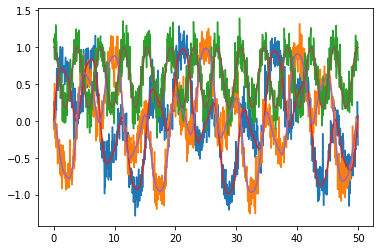

In [159]:

plt.plot(tspace, dataMatTrn[0,:,0])
plt.plot(tspace, dataMatTrn[0,:,1])
plt.plot(tspace, dataMatTrn[0,:,2])

plt.plot(tspace, lablMatTrn[0,:,0])
plt.plot(tspace, lablMatTrn[0,:,1])
plt.plot(tspace, lablMatTrn[0,:,2])


## Create CNN

In [160]:
input_shape = (steps, 3)
def create_CNN():
    # instantiate model
    model = Sequential()
    
    model.add(Conv1D(10, kernel_size=50,padding='same',
                     activation='tanh',
                     input_shape=input_shape))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    
    #model.add(Conv1D(10, kernel_size=20,padding='same',
    #                 activation='relu',
    #                 input_shape=input_shape))
    
    model.add(Dropout(0.25))
    model.add(Conv1D(3, kernel_size=20, padding='same',
                     activation='tanh'))
    # compile the model
    optimizerUse = keras.optimizers.SGD(lr=0.01)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizerUse,
                  metrics=['accuracy'])
    
    model.summary()
    
    return model


print('Model created.')
      
# get output from intermediate layer
model_CNN=create_CNN()

print('Model compiled successfully')


Model created.
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 1000, 10)          1510      
_________________________________________________________________
dropout_32 (Dropout)         (None, 1000, 10)          0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 1000, 3)           603       
Total params: 2,113
Trainable params: 2,113
Non-trainable params: 0
_________________________________________________________________
Model compiled successfully


## Train Model

In [161]:
# training parameters
batch_size = 2000
epochs = 100
# train CNN
model_CNN.fit(dataMatTrn, lablMatTrn,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(dataMatTst, lablMatTst))

# evaluate model
#score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
#print()
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])



Train on 2000 samples, validate on 1000 samples
Epoch 1/100
2000/2000 [==============================] - 1s 726us/step - loss: 0.4028 - accuracy: 0.3166 - val_loss: 0.3118 - val_accuracy: 0.4151
Epoch 2/100
2000/2000 [==============================] - 1s 682us/step - loss: 0.3475 - accuracy: 0.4032 - val_loss: 0.2644 - val_accuracy: 0.5265
Epoch 3/100
2000/2000 [==============================] - 1s 669us/step - loss: 0.3017 - accuracy: 0.4811 - val_loss: 0.2257 - val_accuracy: 0.6127
Epoch 4/100
2000/2000 [==============================] - 1s 715us/step - loss: 0.2639 - accuracy: 0.5440 - val_loss: 0.1943 - val_accuracy: 0.6654
Epoch 5/100
2000/2000 [==============================] - 1s 668us/step - loss: 0.2332 - accuracy: 0.5923 - val_loss: 0.1690 - val_accuracy: 0.6969
Epoch 6/100
2000/2000 [==============================] - 1s 659us/step - loss: 0.2081 - accuracy: 0.6290 - val_loss: 0.1485 - val_accuracy: 0.7180
Epoch 7/100
2000/2000 [==============================] - 1s 649us/step

Epoch 57/100
2000/2000 [==============================] - 1s 685us/step - loss: 0.0520 - accuracy: 0.8625 - val_loss: 0.0215 - val_accuracy: 0.9360
Epoch 58/100
2000/2000 [==============================] - 1s 688us/step - loss: 0.0517 - accuracy: 0.8630 - val_loss: 0.0213 - val_accuracy: 0.9365
Epoch 59/100
2000/2000 [==============================] - 1s 728us/step - loss: 0.0514 - accuracy: 0.8634 - val_loss: 0.0211 - val_accuracy: 0.9370
Epoch 60/100
2000/2000 [==============================] - 2s 853us/step - loss: 0.0511 - accuracy: 0.8640 - val_loss: 0.0209 - val_accuracy: 0.9375
Epoch 61/100
2000/2000 [==============================] - 2s 789us/step - loss: 0.0508 - accuracy: 0.8648 - val_loss: 0.0207 - val_accuracy: 0.9379
Epoch 62/100
2000/2000 [==============================] - 2s 802us/step - loss: 0.0506 - accuracy: 0.8654 - val_loss: 0.0206 - val_accuracy: 0.9384
Epoch 63/100
2000/2000 [==============================] - 2s 795us/step - loss: 0.0503 - accuracy: 0.8655 - val_

## Get intermediate layer

In [162]:
get_output = kb.function([model_CNN.layers[0].input],
                                  [model_CNN.layers[2].output])
layer_output = get_output([dataMatTst])[0]



## Plot results

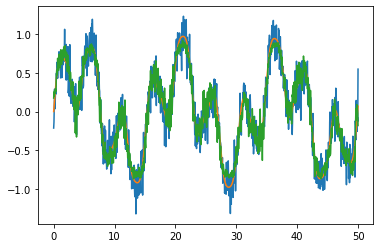

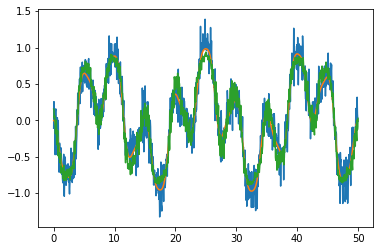

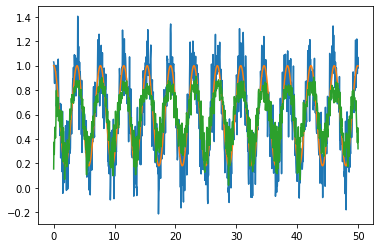

In [163]:
PlotData = 55;

plt.figure()
plt.plot(tspace,dataMatTrn[PlotData,:,0])
plt.plot(tspace,lablMatTrn[PlotData,:,0])
plt.plot(tspace,layer_output[PlotData,:,0])

plt.figure()
plt.plot(tspace,dataMatTrn[PlotData,:,1])
plt.plot(tspace,lablMatTrn[PlotData,:,1])
plt.plot(tspace,layer_output[PlotData,:,1])

plt.figure()
plt.plot(tspace,dataMatTrn[PlotData,:,2])
plt.plot(tspace,lablMatTrn[PlotData,:,2])
plt.plot(tspace,layer_output[PlotData,:,2])


